In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, BatchNormalization
#from keras.layers import Conv1D, MaxPooling1D, Conv1DTranspose
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from IPython.display import Audio

In [4]:
npz = '/floyd/input/audio_gan_clips/homework_discovery_clips_stepped_4beats.npz'

data_file = np.load(npz)
dataset = data_file['X']
track_length = dataset.shape[1]
dataset.shape

(15122, 44863)

In [5]:
def loop_sample(sample, loop_count=4):
  tmp = sample
  for i in range(loop_count - 1):
    sample = np.concatenate((tmp, sample))

  return sample

sample = dataset[-1000]
sample = loop_sample(sample)
Audio(sample, rate=22500)

In [6]:
print(sample)

[ 0.02006278  0.02170148  0.03546087 ... -0.3526271  -0.28023887
 -0.21728146]


(179452,)


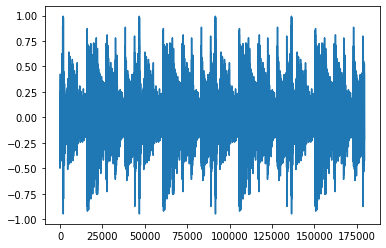

In [7]:
print(sample.shape)
plt.plot(sample)
plt.show()

In [8]:
def define_discriminator(in_shape):
    model = Sequential()

    # 2D CNN
    # Total params: 22,978,177
    model.add(Dense(512, activation='relu', input_shape=(in_shape,)))
    model.add(Dropout(0.4))
    model.add(Reshape((8, 8, 8)))
    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    
    # 1D CNN
    # Total params: 11,502,017
    #model.add(Dense(256, activation='relu', input_shape=(in_shape,)))
    #model.add(Dropout(0.4))
    #model.add(Reshape((16, 16)))
    #model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(MaxPooling1D(pool_size=2))
    
    # Fully connected
    #model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.4))
    #model.add(Dense(32, activation='relu'))
    #model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = define_discriminator(track_length)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               22970368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          4672      
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

In [9]:
def train_discriminator(model, dataset, X_real, y_real, X_fake, y_fake, n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)

    # manually enumerate epochs
    for i in range(n_iter):

        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        
        # summarize performance
        print('>%d real=%.2f%% fake=%.2f%%' % (i+i, real_acc*100, fake_acc*100))

In [10]:
X_real = dataset
y_real = np.ones(dataset.shape[0])

print(X_real.shape)
print(y_real.shape)

(15122, 44863)
(15122,)


In [11]:
X_fake = ((np.random.rand(dataset.shape[0], dataset.shape[1])) * 2) - 1
y_fake = np.zeros(dataset.shape[0])

print(X_fake.shape)
print(y_fake.shape)

(15122, 44863)
(15122,)


In [12]:
# Conv1D
# >198 real=99.99% fake=99.96%

train_discriminator(model, dataset, X_real, y_real, X_fake, y_fake)

>0 real=0.60% fake=99.20%
>2 real=18.25% fake=99.35%
>4 real=43.64% fake=99.56%
>6 real=58.31% fake=99.77%
>8 real=66.92% fake=99.81%
>10 real=73.72% fake=99.88%
>12 real=78.03% fake=99.90%
>14 real=81.69% fake=99.94%
>16 real=84.00% fake=99.98%
>18 real=85.97% fake=99.96%
>20 real=88.17% fake=99.97%
>22 real=89.58% fake=99.99%
>24 real=90.77% fake=99.99%
>26 real=91.99% fake=99.99%
>28 real=93.00% fake=100.00%
>30 real=93.79% fake=100.00%
>32 real=94.81% fake=100.00%
>34 real=95.48% fake=100.00%
>36 real=96.09% fake=100.00%
>38 real=96.79% fake=100.00%
>40 real=97.28% fake=100.00%
>42 real=97.73% fake=100.00%
>44 real=97.80% fake=100.00%
>46 real=98.17% fake=100.00%
>48 real=98.54% fake=100.00%
>50 real=98.73% fake=100.00%
>52 real=98.99% fake=100.00%
>54 real=99.06% fake=100.00%
>56 real=99.25% fake=100.00%
>58 real=99.32% fake=100.00%
>60 real=99.47% fake=100.00%
>62 real=99.56% fake=100.00%
>64 real=99.53% fake=100.00%
>66 real=99.72% fake=100.00%
>68 real=99.73% fake=100.00%
>70 r

In [18]:
def define_generator(latent_dim, track_length):
    model = Sequential()

    # Conv2D
    n_nodes = 64
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 4)))
    model.add(Conv2DTranspose(16, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())

    # Conv1D
    #n_nodes = 256
    #model.add(Dense(n_nodes, input_dim=latent_dim))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(Reshape((16,16)))
    #model.add(Conv1DTranspose(64, kernel_size=4, strides=2, padding='same'))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(Conv1DTranspose(64, kernel_size=4, strides=2, padding='same'))
    #model.add(LeakyReLU(alpha=0.2))
    #odel.add(Conv1DTranspose(128, kernel_size=4, strides=2, padding='same'))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(Conv1DTranspose(128, kernel_size=4, strides=2, padding='same'))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(Flatten())

    # FIRST
    #n_nodes = latent_dim
    #model.add(Dense(n_nodes, input_dim=latent_dim))
    #model.add(Dropout(0.4))
    #model.add(Dense(500))
    #model.add(Dropout(0.4))
    #model.add(Dense(track_length, activation='tanh'))

    # From image
    # foundation for 7x7 image
    #n_nodes = 128 * 7 * 7
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    #model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    #model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    #model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    #model.add(LeakyReLU(alpha=0.2))
    #model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    
    model.add(Dense(track_length, activation='tanh'))
    return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim, track_length)
# summarize the model
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                6464      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 4, 4, 4)           0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 16)          1040      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 44863)            

In [19]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# create the discriminator
d_model = define_discriminator(track_length)
# create the generator
g_model = define_generator(latent_dim, track_length)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_11 (Sequential)   (None, 44863)             45992079  
_________________________________________________________________
sequential_10 (Sequential)   (None, 1)                 22975617  
Total params: 68,967,696
Trainable params: 45,992,079
Non-trainable params: 22,975,617
_________________________________________________________________


In [20]:
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate real class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

def generate_latent_points(latent_dim, n_samples):
    # generate point in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)

In [21]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    d_losses = []
    g_losses = []
    
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # update discriminatoor model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            d_losses.append(d_loss)
            g_losses.append(g_loss)
            # summarize loss on this batch
            #print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 5 == 0:
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        #    summarize_performance(i, g_model, d_model, dataset, latent_dim)
        
    plt.plot(d_losses)
    plt.plot(g_losses)
    plt.show()

/usr/local/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>10, 59/59, d=0.546, g=1.461
>20, 59/59, d=0.519, g=1.751
>30, 59/59, d=0.432, g=1.726
>40, 59/59, d=0.309, g=2.063
>50, 59/59, d=0.290, g=2.488
>60, 59/59, d=0.197, g=2.991
>70, 59/59, d=0.149, g=3.199
>80, 59/59, d=0.246, g=3.247
>90, 59/59, d=0.147, g=3.645
>100, 59/59, d=0.173, g=3.845
>110, 59/59, d=0.194, g=3.864
>120, 59/59, d=0.135, g=4.795
>130, 59/59, d=0.114, g=4.767
>140, 59/59, d=0.151, g=4.396
>150, 59/59, d=0.140, g=4.283
>160, 59/59, d=0.268, g=2.837
>170, 59/59, d=0.391, g=4.835
>180, 59/59, d=0.225, g=2.213
>190, 59/59, d=0.229, g=2.671
>200, 59/59, d=0.272, g=2.882
>210, 59/59, d=0.191, g=3.889
>220, 59/59, d=0.151, g=3.928
>230, 59/59, d=0.185, g=2.230
>240, 59/59, d=0.132, g=3.279
>250, 59/59, d=0.177, g=3.533
>260, 59/59, d=0.060, g=3.900
>270, 59/59, d=0.562, g=21.209
>280, 59/59, d=0.151, g=3.352
>290, 59/59, d=0.053, g=8.855
>300, 59/59, d=0.099, g=10.296
>310, 59/59, d=0.174, g=3.781
>320, 59/59, d=0.055, g=3.685
>330, 59/59, d=0.050, g=6.956
>340, 59/59, d=0.

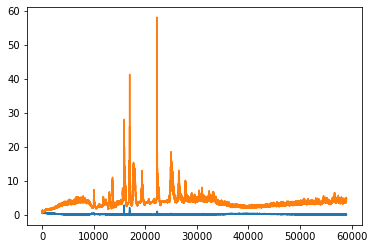

In [29]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator(track_length)
# create the generator
g_model = define_generator(latent_dim, track_length)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
#dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000)

In [30]:
g_model.save('audio_gan_model')

In [31]:
n_samples = 10
x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)

In [32]:
print(x_fake.shape)
print(y_fake.shape)

(10, 44863)
(10, 1)


In [33]:
np.max(x_fake[0])

0.86054087

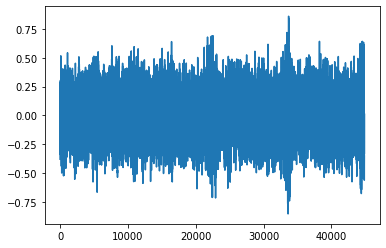

In [34]:
plt.plot(x_fake[0])

In [35]:
loop = loop_sample(x_fake[0])
Audio(loop, rate=22500)